In [1]:
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import interp1d
import pandas as pd
from scipy.special import jv
from scipy.linalg import solve_sylvester
from scipy.ndimage import binary_fill_holes
import time
from ipywidgets import interact
from ipywidgets import IntSlider


def get_square_H(s,skin_depth,resolution):
    k = (1-1j)/skin_depth
    dx = s/(resolution+1) #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).            
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =1 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution):
    k = (1-1j)/skin_depth
    cylindH = np.ones([resolution+2,resolution+2],dtype=np.complex_)
    demon = 1/jv(0,d/2*k)
    for i in range(1,resolution+1):
        for j in range(1,resolution+1):
            if ((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*4<=resolution**2:
                cylindH[i][j] = jv(0,np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*d/(resolution)*k)*demon
    return cylindH

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing

    # Define the initial condition
    # z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    resolution = len(mask)
    dx = s/(resolution + 1)  # grid spacing
    phases = np.zeros(iterations)

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    plt.show()
    return z

def get_rect_H(l,w,skin_depth,resolution,iters):
    big = max(l,w)
    ratio = min(l,w)/big
    mask = np.zeros([resolution,resolution],dtype=np.float64)
    for i in range(resolution):
        if abs(i/(resolution-1)-.5)< ratio/2: #so the difference from the center point (.5) is ratio/2 or less for each side
            row = [1]*resolution
            row[0] = 0
            row[-1] = 0
            mask[i] = np.array([row])
    return get_shape_H(mask,big,skin_depth,iters)
    # fig = plt.figure(constrained_layout = True)
    # ax = fig.add_subplot(1, 1, 1)
    # ax.imshow(np.absolute(mask))
    # ax.set_xticks(np.arange(0, resolution, step=10))
    # ax.set_yticks(np.arange(0, resolution, step=10))
    # return ''
    
def get_skin_depth(rho,frequency=671111):
    return (rho/(4e-7*np.pi * np.pi *frequency))**.5

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing
    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])
    return z

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

def get_area(mask,s):
    count = 0
    l = len(mask)
    for i in range(l):
        for j in range(l):
            if mask[i][j]:
                count += 1
    return (s**2)*count/((l-2)**2) #this gives area in whatever units are for s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def adjustsize(data, start,end,resolution,outside_val=0):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.zeros([n,n],dtype=np.complex_)+outside_val
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

Area Simulation

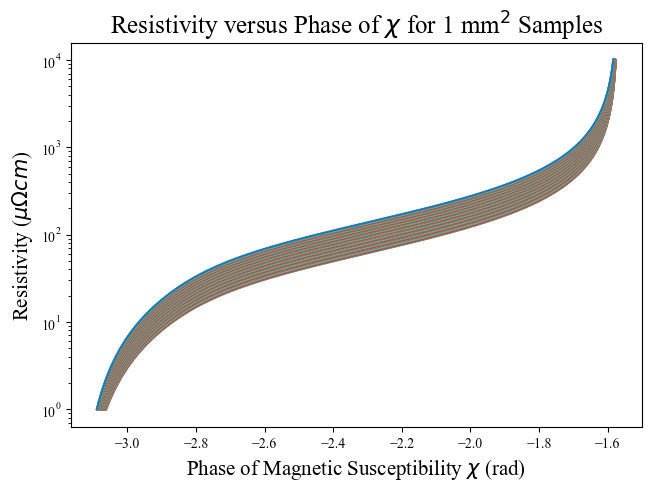

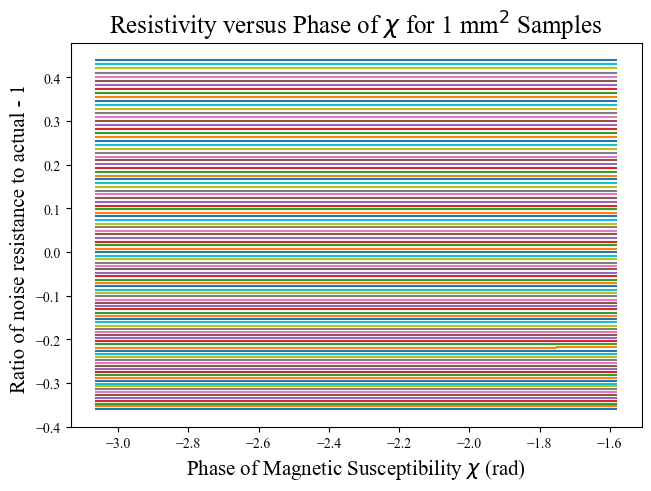

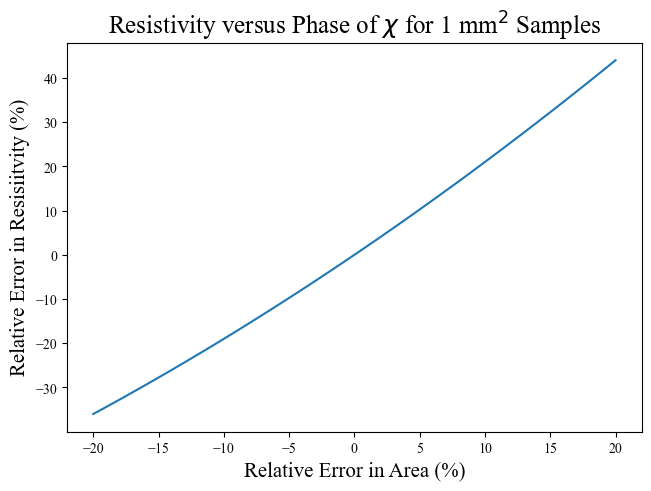

In [2]:

# I am off by some area dA, how much will the resisitivity measurement be affected? What is the change in resisitance?
# Namely, I want to find the largest change in phase and see how that effects the resistivity. 
# 
# For a given error in area dA, I want to characterize the uncertianty added in the resistivity measurement. 

# da = a*(1.05)**.5 #This is 5% error in area measurement, 
r0 = 1e-3 #radius in m
rs = np.linspace(.8,1.2,101)*r0
rhos4 = np.logspace(-8,-4,1000)
chis4 = np.zeros([len(rs),len(rhos4)],dtype=np.float64)

for i, rho in enumerate(rhos4):
    for j, r in enumerate(rs):
        rk =(1-1j)*r/get_skin_depth(rho)
        chis4[j][i] = np.angle(2/rk*jv(1,rk)/jv(0,rk)-1) #this gives a matrix of all the magnetic susceptiblties for the given radii and rhos

startchi = max(np.transpose(chis4)[0])#smallest radius max angle
endchi = min(np.transpose(chis4)[-1])#largest radius max angle
og = np.logical_not(rs != r0)
chirange = chis4[og][np.logical_and(chis4[og]>= startchi, chis4[og] <= endchi)]
resist2s = np.zeros([len(rs),len(chirange)],dtype=np.float64)

for i, r in enumerate(rs):
    resist2s[i] = np.array(np.interp(chirange,chis4[i],rhos4))
resist2s = resist2s/resist2s[og]#this normalizes the resistivies for each r

fig = plt.figure(constrained_layout = True)
cx = fig.add_subplot(1, 1, 1)
for i in range(len(rs)):    
    cx.plot(chis4[i],rhos4*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)

fig2 = plt.figure(constrained_layout = True)
ax = fig2.add_subplot(1, 1, 1)
for i in range(len(rs)):    
    ax.plot(chirange,resist2s[i]-1)
# ax.set_yscale('log')
#interpelate over r0 range of cis
ax.set_ylabel('Ratio of noise resistance to actual - 1 ',fontsize = 15)
ax.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
ax.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)

rest_perts = [] # this is the percentage off for each radius change. Note, this percentage stays constant across the phase range
for i in range(len(rs)):
    rest_perts.append(100*(resist2s[i][0]-1))


fig3 = plt.figure(constrained_layout = True)
bx = fig3.add_subplot(1, 1, 1) 
bx.plot(100*rs/r0-100,rest_perts)
# bx.set_yscale('log')
bx.set_ylabel('Relative Error in Resisiitvity (%)',fontsize = 15)
bx.set_xlabel('Relative Error in Area (%)',fontsize = 15)
_ = bx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)